In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from filenames import vpn_file_names, nvpn_file_names, file_name_groups


In [30]:
server_ip_to_filename = {}

def insert_server_ip_filename(is_vpn, server_ip, filename):
    if server_ip not in server_ip_to_filename:
        server_ip_to_filename[server_ip] = {"vpn": [], "nvpn": []}
    server_ip_to_filename[server_ip][is_vpn].append(filename)

def load_csv_file_group(group_idx):
    global server_ip_to_filename
    dfs = []
    server_ip_to_filename = {}
    file_name_group = file_name_groups[group_idx]
    for filename, is_vpn in file_name_group:
        filename = filename.split(".")[0]
        try:
            df = pd.read_csv(f"./{is_vpn}_csv/{filename}.csv")
            df_len = len(df)
            df['source'] = filename
            df['weight'] = 1 / df_len
            src_series = df['src IP']
            dst_series = df['dst IP']
            series = pd.concat([src_series, dst_series])
            server_IP = series.value_counts().idxmax()
            max_freq = series.value_counts().max()
            if len(src_series) != max_freq:
                print(idx, filename, len(src_series), max_freq)
                continue
            insert_server_ip_filename(is_vpn, server_IP, filename)
            df = df[df['src IP'] != server_IP]
            dfs.append(df)

        except:
            print(filename + ".csv")
            pass


    for server_ip, value in server_ip_to_filename.items():
        print(server_ip, value)

    df = pd.concat(dfs)
    df['src freq'] = df.groupby('src IP')['src IP'].transform('count') * df['weight']
    df['log_freq'] = np.log(df['src freq'])
    df['log_length'] = np.log(df['length'])

    dst_count = df['dst IP'].value_counts()

    return df, server_ip_to_filename

def load_nfs_file_group(group_idx):
    global server_ip_to_filename
    dfs = []
    file_name_group = file_name_groups[group_idx]
    for filename, is_vpn in file_name_group:
        filename = filename.split(".")[0]
        try:
            df = pd.read_csv(f"./nfs/{filename}.csv")
        except:
            print(filename + ".csv")
            pass
        df['log_freq'] = np.log(df['src_freq'])
        dfs.append(df)
    df = pd.concat(dfs)

    return df

/tmp/ipykernel_1848768/3039682729.py:56: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"./nfs/{filename}.csv")


1.0


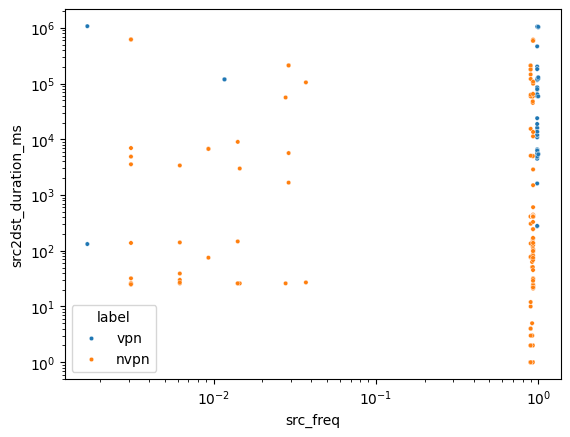

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from nfstream import NFPlugin, NFStreamer


df = load_nfs_file_group(-1)
file_names = [file_name[0] for file_name in file_name_groups[3]]
df = df[df['file_name'].isin(file_names)]

#sns.scatterplot(data=df, x='src_freq', y='src2dst_bytes', hue='label', s=10.0, alpha=1.0)
sns.scatterplot(data=df, x='src_freq', y='src2dst_duration_ms', hue='label', s=10.0, alpha=1.0)
plt.xscale('log')
plt.yscale('log')



X = df[["src_freq", "src2dst_duration_ms"]]
y = df["label"].apply(lambda x: 1 if x == 'vpn' else 0)
dataset_size = len(X)
train_mask = np.random.rand(dataset_size) < 0.7
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[~train_mask]
y_test = y[~train_mask]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print((prediction == y_test).sum() / len(y_test))



In [5]:
ip_info = {}
for row in df.itertuples():
    print(row)
    break
    if row._5 in ip_info:
        ip_info[row._5][row.label] += 1
    else:
        ip_info[row._5] = {"vpn": 0, "nvpn": 0}
        ip_info[row._5][row.label] += 1
for k, v in ip_info.items():
    if v['vpn'] > 0 and v['nvpn'] > 0:
        print(k, v)


Pandas(Index=0, _1=0, expiration_id=0, src_ip='10.8.8.178', src_mac='00:00:00:00:00:00', src_oui='00:00:00', src_port=15685, dst_ip='157.55.130.172', dst_mac='00:00:00:00:00:00', dst_oui='00:00:00', dst_port=40027, protocol=17, ip_version=4, vlan_id=0, tunnel_id=0, bidirectional_first_seen_ms=1433356961219, bidirectional_last_seen_ms=1433356961424, bidirectional_duration_ms=205, bidirectional_packets=2, bidirectional_bytes=212, src2dst_first_seen_ms=1433356961219, src2dst_last_seen_ms=1433356961219, src2dst_duration_ms=0, src2dst_packets=1, src2dst_bytes=163, dst2src_first_seen_ms=1433356961424, dst2src_last_seen_ms=1433356961424, dst2src_duration_ms=0, dst2src_packets=1, dst2src_bytes=49, application_name='Skype_Teams.Skype_TeamsCall', application_category_name='VoIP', application_is_guessed=0, application_confidence=6, requested_server_name=nan, client_fingerprint=nan, server_fingerprint=nan, user_agent=nan, content_type=nan, src_freq=740, log_freq=6.606650186198215)


In [8]:
fdf_dict = {
    'IP': [],
    'vpn': [],
    'nvpn': [],
    'total': [],
    'ratio': []
}
for ip, info in ip_info.items():
    fdf_dict['IP'].append(ip)
    fdf_dict['vpn'].append(info['vpn'])
    fdf_dict['nvpn'].append(info['nvpn'])
    fdf_dict['total'].append(info['vpn'] + info['nvpn'])
    fdf_dict['ratio'].append(info['vpn'] / (info['vpn'] + info['nvpn']))

fdf = pd.DataFrame(fdf_dict)

In [9]:
df, server_ip_to_filename = load_file_group(3)
plt.clf()
sns.scatterplot(data=df, x="log_freq", y="log_length", hue="label", s=10.0, alpha=0.2)
#sns.scatterplot(data=df, x="log_freq", y="log_length", hue="source", s=10.0, alpha=0.2)


NameError: name 'load_file_group' is not defined

In [12]:
predictions = np.array(predictions)
print(predictions.shape)

(1680, 1)


In [13]:
print(predictions.sum())

6
